In [1]:
import time
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from scipy.io import loadmat
import networkx as nx
import multiprocessing as mp
import torch.nn.functional as F
from functools import partial
import random
from sklearn.metrics import roc_auc_score, f1_score
from copy import deepcopy
from scipy.spatial.distance import pdist,squareform
import torch.nn as nn
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn import init
import torch.optim as optim
import networkx as nx
import tensorflow as tf
import pandas as pd

In [2]:
def split_arti(labels, c_train_num):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)
    c_num_mat[:,1] = 25
    c_num_mat[:,2] = 55

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        train_idx = train_idx + c_idx[:c_train_num[i]]
        c_num_mat[i,0] = c_train_num[i]

        val_idx = val_idx + c_idx[c_train_num[i]:(c_train_num[i]+int(c_train_num[i]*.2))]
        test_idx = test_idx + c_idx[int(c_train_num[i]+(c_train_num[i]*.2)):]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [3]:
def src_upsample(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            for j in range(c_portion):
                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            for j in range(c_portion):
                num = int(new_chosen.shape[0])
                new_chosen = new_chosen[:num]

                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)
            
            num = int(new_chosen.shape[0]*portion_rest)
            new_chosen = new_chosen[:num]

            if chosen is None:
                chosen = new_chosen
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(features[chosen,:])
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [4]:
def src_smote(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None
    new_features = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            portion_rest = (avg_number/new_chosen.shape[0]) - c_portion

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            
        for j in range(c_portion):
            num = int(new_chosen.shape[0])
            new_chosen = new_chosen[:num]

            chosen_embed = features[new_chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

            if chosen is None:
                chosen = new_chosen
                new_features = embed
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
                new_features = torch.cat((new_features, embed),0)
            
        num = int(new_chosen.shape[0]*portion_rest)
        new_chosen = new_chosen[:num]

        chosen_embed = features[new_chosen,:]
        distance = squareform(pdist(chosen_embed.detach()))
        np.fill_diagonal(distance,distance.max()+100)

        idx_neighbor = distance.argmin(axis=-1)
            
        interp_place = random.random()
        embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

        if chosen is None:
            chosen = new_chosen
            new_features = embed
        else:
            chosen = torch.cat((chosen, new_chosen), 0)
            new_features = torch.cat((new_features, embed),0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(new_features)
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [5]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [6]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        #for 3_D batch, need a loop!!!


        if self.bias is not None:
            return output + self.bias
        else:
            return output

#Multihead attention layer
class MultiHead(Module):#currently, allowed for only one sample each time. As no padding mask is required.
    def __init__(
        self,
        input_dim,
        num_heads,
        kdim=None,
        vdim=None,
        embed_dim = 128,#should equal num_heads*head dim
        v_embed_dim = None,
        dropout=0.1,
        bias=True,
    ):
        super(MultiHead, self).__init__()
        self.input_dim = input_dim
        self.kdim = kdim if kdim is not None else input_dim
        self.vdim = vdim if vdim is not None else input_dim
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.v_embed_dim = v_embed_dim if v_embed_dim is not None else embed_dim

        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.bias = bias
        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"

        assert self.v_embed_dim % num_heads ==0, "v_embed_dim must be divisible by num_heads"

        self.scaling = self.head_dim ** -0.5


        self.q_proj = nn.Linear(self.input_dim, self.embed_dim, bias=bias)
        self.k_proj = nn.Linear(self.kdim, self.embed_dim, bias=bias)
        self.v_proj = nn.Linear(self.vdim, self.v_embed_dim, bias=bias)

        self.out_proj = nn.Linear(self.v_embed_dim, self.v_embed_dim//self.num_heads, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        if True:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)
        else:
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)

        nn.init.normal_(self.out_proj.weight)

        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.)

        if self.bias:
            nn.init.constant_(self.k_proj.bias, 0.)
            nn.init.constant_(self.v_proj.bias, 0.)
            nn.init.constant_(self.q_proj.bias, 0.)

    def forward(
        self,
        query,
        key,
        value,
        need_weights: bool = False,
        need_head_weights: bool = False,
    ):
        """Input shape: Time x Batch x Channel
        Args:
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True

        batch_num, node_num, input_dim = query.size()

        assert key is not None and value is not None

        #project input
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)
        q = q * self.scaling

        #compute attention
        q = q.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        k = k.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        v = v.view(batch_num, node_num, self.num_heads, self.vdim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.vdim)
        attn_output_weights = torch.bmm(q, k.transpose(-1,-2))
        attn_output_weights = F.softmax(attn_output_weights, dim=-1)

        #drop out
        attn_output_weights = F.dropout(attn_output_weights, p=self.dropout, training=self.training)

        #collect output
        attn_output = torch.bmm(attn_output_weights, v)
        attn_output = attn_output.view(batch_num, self.num_heads, node_num, self.vdim).transpose(-2,-3).contiguous().view(batch_num, node_num, self.v_embed_dim)
        attn_output = self.out_proj(attn_output)


        if need_weights:
            attn_output_weights = attn_output_weights #view: (batch_num, num_heads, node_num, node_num)
            return attn_output, attn_output_weights.sum(dim=1) / self.num_heads
        else:
            return attn_output


#Graphsage layer
class SageConv(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, in_features, out_features, bias=False):
        super(SageConv, self).__init__()

        self.proj = nn.Linear(in_features*2, out_features, bias=bias)

        self.reset_parameters()

        #print("note: for dense graph in graphsage, require it normalized.")

    def reset_parameters(self):

        nn.init.normal_(self.proj.weight)

        if self.proj.bias is not None:
            nn.init.constant_(self.proj.bias, 0.)

    def forward(self, features, adj):
        """
        Args:
            adj: can be sparse or dense matrix.
        """

        #fuse info from neighbors. to be added:
        if not isinstance(adj, torch.sparse.FloatTensor):
            if len(adj.shape) == 3:
                neigh_feature = torch.bmm(adj, features) / (adj.sum(dim=1).reshape((adj.shape[0], adj.shape[1],-1))+1)
            else:
                neigh_feature = torch.mm(adj, features) / (adj.sum(dim=1).reshape(adj.shape[0], -1)+1)
        else:
            #print("spmm not implemented for batch training. Note!")
            
            neigh_feature = torch.spmm(adj, features) / (adj.to_dense().sum(dim=1).reshape(adj.shape[0], -1)+1)

        #perform conv
        data = torch.cat([features,neigh_feature], dim=-1)
        combined = self.proj(data)

        return combined

#GraphAT layers

class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        if isinstance(adj, torch.sparse.FloatTensor):
            adj = adj.to_dense()

        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""
    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)

    
class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1.414)
                
        self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1.414)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]
        edge = adj.nonzero().t()

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N,1), device=dv))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out
        
        h_prime = h_prime.div(e_rowsum)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'




#--------------
### models ###
#--------------

#gcn_encode
class GCN_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class GCN_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En2, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class GCN_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(GCN_Classifier, self).__init__()

        self.gc1 = GraphConvolution(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x

#sage model

class Sage_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En, self).__init__()

        self.sage1 = SageConv(nfeat, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class Sage_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En2, self).__init__()

        self.sage1 = SageConv(nfeat, nhid)
        self.sage2 = SageConv(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.sage2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class Sage_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Sage_Classifier, self).__init__()

        self.sage1 = SageConv(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x


#GAT model

class GAT_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En, self).__init__()

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):

        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))

        return x

class GAT_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En2, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.attentions_2 = [GraphAttentionLayer(nembed, nembed, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions_2):
            self.add_module('attention2_{}'.format(i), attention)

        self.out_proj_2 = nn.Linear(nembed * nheads, nembed)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)
        nn.init.normal_(self.out_proj_2.weight,std=0.05)


    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = torch.cat([att(x, adj) for att in self.attentions_2], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj_2(x))
        return x

class GAT_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout, alpha=0.2, nheads=8):
        super(GAT_Classifier, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nembed, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nhid)

        self.dropout = dropout
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = self.mlp(x)

        return x

class MLP_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(MLP_En, self).__init__()

        self.mlp1 = nn.Linear(nfeat, nembed)
        self.dropout = dropout
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp1.weight,std=0.05)
    def forward(self, x, adj):
        x = F.relu(self.mlp1(x))
        x = F.dropout(x, self.dropout, training=self.training)
        return x


class Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Classifier, self).__init__()

        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = self.mlp(x)

        return x

class Decoder(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, nembed, dropout=0.1):
        super(Decoder, self).__init__()
        self.dropout = dropout

        self.de_weight = Parameter(torch.FloatTensor(nembed, nembed))

        self.reset_parameters()


    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.de_weight.size(1))
        self.de_weight.data.uniform_(-stdv, stdv)


    def forward(self, node_embed):
        
        combine = F.linear(node_embed, self.de_weight)
        adj_out = torch.sigmoid(torch.mm(combine, combine.transpose(-1,-2)))

        return adj_out

In [7]:
def split_genuine(labels):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        c_num = len(c_idx)
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        if c_num <4:
            if c_num < 3:
                print("too small class type")
                ipdb.set_trace()
            c_num_mat[i,0] = 1
            c_num_mat[i,1] = 1
            c_num_mat[i,2] = 1
        else:
            c_num_mat[i,0] = int(c_num/4)
            c_num_mat[i,1] = int(c_num/4)
            c_num_mat[i,2] = int(c_num/2)


        train_idx = train_idx + c_idx[:c_num_mat[i,0]]

        val_idx = val_idx + c_idx[c_num_mat[i,0]:c_num_mat[i,0]+c_num_mat[i,1]]
        test_idx = test_idx + c_idx[c_num_mat[i,0]+c_num_mat[i,1]:c_num_mat[i,0]+c_num_mat[i,1]+c_num_mat[i,2]]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [8]:
data=pd.read_csv("interactions_smote.csv")
data['edge']=data['Gene Symbol']+',' +data['Interactor Symbol']
Graphtype = nx.Graph()
data['edge']=data['edge'].astype(str)
g = nx.parse_edgelist(data['edge'], delimiter=',', create_using=Graphtype,)
adj=nx.adjacency_matrix(g,weight=None)
adj=adj.toarray()
node_features = np.loadtxt('node_features_smote.txt')
labels = np.loadtxt('Multi-Labels.txt')
#labels = np.loadtxt('Labels.txt')

C:\Users\Kyle\AppData\Local\Temp\ipykernel_21844\55265982.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj=nx.adjacency_matrix(g,weight=None)


In [9]:
labels=torch.LongTensor(labels)
features=torch.LongTensor(node_features)
adj=torch.LongTensor(adj)
class_sample_num = 4000
c_train_num = []
for i in range(labels.max().item() + 1):
    if i > labels.max().item()-1: #only imbalance the last classes
        c_train_num.append(int(class_sample_num))

    else:
        c_train_num.append(class_sample_num)

In [10]:
#for i in range(4):
for i in range(7):
        print(i)
        print("-----------------------------------")
        idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)
        adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=3)
        #adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=1)
        print("-----------------------------------")

0
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 214
2-th class sample number: 530
3-th class sample number: 69
-----------------------------------
1
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 428
2-th class sample number: 1060
3-th class sample number: 138
-----------------------------------
2
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 856
2-th class sample number: 2120
3-th class sample number: 276
-----------------------------------
3
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 1712
2-th class sample number: 4240
3-th class sample number: 552
-----------------------------------
4
-----------------------------------
0-th class sample number: 11403
1-th class sample number: 3424
2-th class sample number: 8240
3-th class sample number: 1104
-----------------------------------
5
------------

In [11]:
idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)

0-th class sample number: 11403
1-th class sample number: 14848
2-th class sample number: 20240
3-th class sample number: 8416


In [12]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [13]:
encoder = MLP_En(nfeat=features.shape[1],
        nhid=1,
        nembed=1,
        dropout=0)
classifier = Classifier(nembed=1, 
        nhid=1, 
        nclass=labels.max().item() + 1, 
        dropout=0)
decoder = Decoder(nembed=1,
        dropout=0)


optimizer_en = optim.AdamW(encoder.parameters(),
                       lr=0.001,weight_decay=5e-4,eps=1e-04)
optimizer_cls = optim.AdamW(classifier.parameters(),
                       lr=0.001,weight_decay=5e-4,eps=1e-04)
optimizer_de = optim.AdamW(decoder.parameters(),
                       lr=0.001,weight_decay=5e-4,eps=1e-04)


In [14]:
features.shape[1]

472

In [15]:
def recon_upsample(embed, labels, idx_train, adj=None, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    avg_number = int(idx_train.shape[0]/(c_largest+1))
    #ipdb.set_trace()
    adj_new = None

    for i in range(im_class_num):
        chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        num = int(chosen.shape[0]*portion)
        if portion == 0:
            c_portion = int(avg_number/chosen.shape[0])
            num = chosen.shape[0]
        else:
            c_portion = 1

        for j in range(c_portion):
            chosen = chosen[:num]

            chosen_embed = embed[chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            new_embed = embed[chosen,:] + (chosen_embed[idx_neighbor[:],:]-embed[chosen,:])*interp_place


            new_labels = labels.new(torch.Size((chosen.shape[0],1))).reshape(-1).fill_(c_largest-i)
            idx_new = np.arange(embed.shape[0], embed.shape[0]+chosen.shape[0])
            idx_train_append = idx_train.new(idx_new)

            embed = torch.cat((embed,new_embed), 0)
            labels = torch.cat((labels,new_labels), 0)
            idx_train = torch.cat((idx_train,idx_train_append), 0)

            if adj is not None:
                if adj_new is None:
                    adj_new = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                else:
                    temp = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                    adj_new = torch.cat((adj_new, temp), 0)

    if adj is not None:
        add_num = adj_new.shape[0]
        new_adj = adj.new(torch.Size((adj.shape[0]+add_num, adj.shape[0]+add_num))).fill_(0.0)
        new_adj[:adj.shape[0], :adj.shape[0]] = adj[:,:]
        new_adj[adj.shape[0]:, :adj.shape[0]] = adj_new[:,:]
        new_adj[:adj.shape[0], adj.shape[0]:] = torch.transpose(adj_new, 0, 1)[:,:]

        return embed, labels, idx_train, new_adj.detach()

    else:
        return embed, labels, idx_train

In [16]:
def train(epoch):
    t = time.time()
    encoder.train()
    classifier.train()
    decoder.train()
    optimizer_en.zero_grad()
    optimizer_cls.zero_grad()
    optimizer_de.zero_grad()

    embed = encoder(features, adj)

    #perform SMOTE in embedding space
    labels_new = labels
    idx_train_new = idx_train
    adj_new = adj

   
    #ipdb.set_trace()
    output = classifier(embed, adj_new)

    loss_train = F.cross_entropy(output[idx_train_new], labels_new[idx_train_new])
    
    acc_train = accuracy(output[idx_train], labels_new[idx_train])
    loss = loss_train
    loss_rec = loss_train
    loss.backward()
    optimizer_en.step()

    optimizer_cls.step()
    loss_val = F.cross_entropy(output[idx_val], labels[idx_val])
    
    acc_val = accuracy(output[idx_val], labels[idx_val])

    print('Epoch: {:05d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_rec: {:.4f}'.format(loss_rec.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))


def test(epoch = 0):
    encoder.eval()
    classifier.eval()
    decoder.eval()
    embed = encoder(features, adj)
    output = classifier(embed, adj)
    loss_test = F.cross_entropy(output[idx_test], labels[idx_test])
    
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

  

    '''
    if epoch==40:
        torch
    '''
    return output


def save_model(epoch):
    saved_content = {}

    saved_content['encoder'] = encoder.state_dict()
    saved_content['decoder'] = decoder.state_dict()
    saved_content['classifier'] = classifier.state_dict()

    torch.save(saved_content, 'model_checkpoint.pth')

    return

def load_model(filename):
    loaded_content = torch.load('checkpoint/{}/{}.pth')

    encoder.load_state_dict(loaded_content['encoder'])
    decoder.load_state_dict(loaded_content['decoder'])
    classifier.load_state_dict(loaded_content['classifier'])

    print("successfully loaded: "+ filename)

    return

In [17]:
encoder = encoder.cuda()
classifier = classifier.cuda()
decoder = decoder.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

In [18]:
adj = torch.tensor(adj, dtype=torch.float)
features = torch.tensor(features, dtype=torch.float)
features = features.cuda()
adj = adj.cuda()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_21844\4161052455.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_21844\4161052455.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float)


In [19]:

t_total = time.time()
for epoch in range(3000):
    train(epoch)

    if epoch % 10 == 0:
        output=test(epoch)

    if epoch % 100 == 0:
        save_model(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
output=test()

Epoch: 00001 loss_train: 1.4978 loss_rec: 1.4978 acc_train: 0.2500 loss_val: 1.4978 acc_val: 0.2500 time: 2.9540s
Test set results: loss= 1.5421 accuracy= 0.1849
Epoch: 00002 loss_train: 1.4974 loss_rec: 1.4974 acc_train: 0.2500 loss_val: 1.4974 acc_val: 0.2500 time: 0.0040s
Epoch: 00003 loss_train: 1.4971 loss_rec: 1.4971 acc_train: 0.2500 loss_val: 1.4971 acc_val: 0.2500 time: 0.0040s
Epoch: 00004 loss_train: 1.4967 loss_rec: 1.4967 acc_train: 0.2500 loss_val: 1.4967 acc_val: 0.2500 time: 0.0060s
Epoch: 00005 loss_train: 1.4964 loss_rec: 1.4964 acc_train: 0.2500 loss_val: 1.4963 acc_val: 0.2500 time: 0.0025s
Epoch: 00006 loss_train: 1.4960 loss_rec: 1.4960 acc_train: 0.2500 loss_val: 1.4960 acc_val: 0.2500 time: 0.0040s
Epoch: 00007 loss_train: 1.4957 loss_rec: 1.4957 acc_train: 0.2500 loss_val: 1.4956 acc_val: 0.2500 time: 0.0030s
Epoch: 00008 loss_train: 1.4953 loss_rec: 1.4953 acc_train: 0.2500 loss_val: 1.4953 acc_val: 0.2500 time: 0.0035s
Epoch: 00009 loss_train: 1.4949 loss_rec

Epoch: 00078 loss_train: 1.4502 loss_rec: 1.4502 acc_train: 0.2536 loss_val: 1.4484 acc_val: 0.2541 time: 0.0025s
Epoch: 00079 loss_train: 1.4494 loss_rec: 1.4494 acc_train: 0.2536 loss_val: 1.4475 acc_val: 0.2541 time: 0.0020s
Epoch: 00080 loss_train: 1.4485 loss_rec: 1.4485 acc_train: 0.2536 loss_val: 1.4465 acc_val: 0.2541 time: 0.0025s
Epoch: 00081 loss_train: 1.4477 loss_rec: 1.4477 acc_train: 0.2536 loss_val: 1.4456 acc_val: 0.2541 time: 0.0015s
Test set results: loss= 1.4809 accuracy= 0.1886
Epoch: 00082 loss_train: 1.4468 loss_rec: 1.4468 acc_train: 0.2536 loss_val: 1.4447 acc_val: 0.2541 time: 0.0025s
Epoch: 00083 loss_train: 1.4459 loss_rec: 1.4459 acc_train: 0.2536 loss_val: 1.4438 acc_val: 0.2541 time: 0.0015s
Epoch: 00084 loss_train: 1.4451 loss_rec: 1.4451 acc_train: 0.2536 loss_val: 1.4429 acc_val: 0.2541 time: 0.0020s
Epoch: 00085 loss_train: 1.4442 loss_rec: 1.4442 acc_train: 0.2536 loss_val: 1.4420 acc_val: 0.2541 time: 0.0020s
Epoch: 00086 loss_train: 1.4434 loss_rec

Epoch: 00187 loss_train: 1.3591 loss_rec: 1.3591 acc_train: 0.3437 loss_val: 1.3557 acc_val: 0.3497 time: 0.0020s
Epoch: 00188 loss_train: 1.3584 loss_rec: 1.3584 acc_train: 0.3429 loss_val: 1.3550 acc_val: 0.3491 time: 0.0025s
Epoch: 00189 loss_train: 1.3577 loss_rec: 1.3577 acc_train: 0.3432 loss_val: 1.3544 acc_val: 0.3503 time: 0.0015s
Epoch: 00190 loss_train: 1.3570 loss_rec: 1.3570 acc_train: 0.3429 loss_val: 1.3537 acc_val: 0.3509 time: 0.0020s
Epoch: 00191 loss_train: 1.3563 loss_rec: 1.3563 acc_train: 0.3445 loss_val: 1.3531 acc_val: 0.3528 time: 0.0015s
Test set results: loss= 1.3599 accuracy= 0.3741
Epoch: 00192 loss_train: 1.3557 loss_rec: 1.3557 acc_train: 0.3459 loss_val: 1.3524 acc_val: 0.3544 time: 0.0020s
Epoch: 00193 loss_train: 1.3550 loss_rec: 1.3550 acc_train: 0.3446 loss_val: 1.3518 acc_val: 0.3550 time: 0.0015s
Epoch: 00194 loss_train: 1.3543 loss_rec: 1.3543 acc_train: 0.3438 loss_val: 1.3511 acc_val: 0.3553 time: 0.0015s
Epoch: 00195 loss_train: 1.3537 loss_rec

Epoch: 00282 loss_train: 1.3118 loss_rec: 1.3118 acc_train: 0.3165 loss_val: 1.3110 acc_val: 0.3138 time: 0.0035s
Epoch: 00283 loss_train: 1.3114 loss_rec: 1.3114 acc_train: 0.3158 loss_val: 1.3107 acc_val: 0.3134 time: 0.0015s
Epoch: 00284 loss_train: 1.3111 loss_rec: 1.3111 acc_train: 0.3159 loss_val: 1.3103 acc_val: 0.3147 time: 0.0030s
Epoch: 00285 loss_train: 1.3107 loss_rec: 1.3107 acc_train: 0.3154 loss_val: 1.3100 acc_val: 0.3144 time: 0.0015s
Epoch: 00286 loss_train: 1.3103 loss_rec: 1.3103 acc_train: 0.3154 loss_val: 1.3097 acc_val: 0.3144 time: 0.0025s
Epoch: 00287 loss_train: 1.3100 loss_rec: 1.3100 acc_train: 0.3159 loss_val: 1.3093 acc_val: 0.3156 time: 0.0015s
Epoch: 00288 loss_train: 1.3096 loss_rec: 1.3096 acc_train: 0.3157 loss_val: 1.3090 acc_val: 0.3153 time: 0.0020s
Epoch: 00289 loss_train: 1.3092 loss_rec: 1.3092 acc_train: 0.3147 loss_val: 1.3086 acc_val: 0.3147 time: 0.0015s
Epoch: 00290 loss_train: 1.3089 loss_rec: 1.3089 acc_train: 0.3147 loss_val: 1.3083 acc_

Epoch: 00388 loss_train: 1.2771 loss_rec: 1.2771 acc_train: 0.3451 loss_val: 1.2783 acc_val: 0.3419 time: 0.0025s
Epoch: 00389 loss_train: 1.2768 loss_rec: 1.2768 acc_train: 0.3449 loss_val: 1.2780 acc_val: 0.3412 time: 0.0020s
Epoch: 00390 loss_train: 1.2765 loss_rec: 1.2765 acc_train: 0.3484 loss_val: 1.2777 acc_val: 0.3441 time: 0.0015s
Epoch: 00391 loss_train: 1.2762 loss_rec: 1.2762 acc_train: 0.3515 loss_val: 1.2775 acc_val: 0.3459 time: 0.0015s
Test set results: loss= 1.2614 accuracy= 0.4174
Epoch: 00392 loss_train: 1.2759 loss_rec: 1.2759 acc_train: 0.3504 loss_val: 1.2772 acc_val: 0.3453 time: 0.0015s
Epoch: 00393 loss_train: 1.2756 loss_rec: 1.2756 acc_train: 0.3504 loss_val: 1.2769 acc_val: 0.3453 time: 0.0020s
Epoch: 00394 loss_train: 1.2753 loss_rec: 1.2753 acc_train: 0.3501 loss_val: 1.2766 acc_val: 0.3456 time: 0.0015s
Epoch: 00395 loss_train: 1.2750 loss_rec: 1.2750 acc_train: 0.3537 loss_val: 1.2763 acc_val: 0.3497 time: 0.0015s
Epoch: 00396 loss_train: 1.2747 loss_rec

Epoch: 00500 loss_train: 1.2465 loss_rec: 1.2465 acc_train: 0.3936 loss_val: 1.2486 acc_val: 0.3944 time: 0.0020s
Epoch: 00501 loss_train: 1.2462 loss_rec: 1.2462 acc_train: 0.3929 loss_val: 1.2483 acc_val: 0.3928 time: 0.0020s
Test set results: loss= 1.2410 accuracy= 0.3792
Epoch: 00502 loss_train: 1.2460 loss_rec: 1.2460 acc_train: 0.3928 loss_val: 1.2481 acc_val: 0.3928 time: 0.0020s
Epoch: 00503 loss_train: 1.2457 loss_rec: 1.2457 acc_train: 0.3927 loss_val: 1.2479 acc_val: 0.3928 time: 0.0015s
Epoch: 00504 loss_train: 1.2455 loss_rec: 1.2455 acc_train: 0.3929 loss_val: 1.2476 acc_val: 0.3928 time: 0.0020s
Epoch: 00505 loss_train: 1.2452 loss_rec: 1.2452 acc_train: 0.3921 loss_val: 1.2474 acc_val: 0.3922 time: 0.0015s
Epoch: 00506 loss_train: 1.2450 loss_rec: 1.2450 acc_train: 0.3921 loss_val: 1.2472 acc_val: 0.3909 time: 0.0020s
Epoch: 00507 loss_train: 1.2448 loss_rec: 1.2448 acc_train: 0.3950 loss_val: 1.2469 acc_val: 0.3922 time: 0.0015s
Epoch: 00508 loss_train: 1.2445 loss_rec

Epoch: 00593 loss_train: 1.2267 loss_rec: 1.2267 acc_train: 0.4144 loss_val: 1.2294 acc_val: 0.4178 time: 0.0025s
Epoch: 00594 loss_train: 1.2266 loss_rec: 1.2266 acc_train: 0.4144 loss_val: 1.2292 acc_val: 0.4178 time: 0.0020s
Epoch: 00595 loss_train: 1.2264 loss_rec: 1.2264 acc_train: 0.4156 loss_val: 1.2291 acc_val: 0.4184 time: 0.0015s
Epoch: 00596 loss_train: 1.2262 loss_rec: 1.2262 acc_train: 0.4156 loss_val: 1.2289 acc_val: 0.4184 time: 0.0015s
Epoch: 00597 loss_train: 1.2260 loss_rec: 1.2260 acc_train: 0.4156 loss_val: 1.2287 acc_val: 0.4184 time: 0.0030s
Epoch: 00598 loss_train: 1.2258 loss_rec: 1.2258 acc_train: 0.4156 loss_val: 1.2285 acc_val: 0.4184 time: 0.0020s
Epoch: 00599 loss_train: 1.2256 loss_rec: 1.2256 acc_train: 0.4157 loss_val: 1.2283 acc_val: 0.4184 time: 0.0025s
Epoch: 00600 loss_train: 1.2254 loss_rec: 1.2254 acc_train: 0.4157 loss_val: 1.2281 acc_val: 0.4184 time: 0.0020s
Epoch: 00601 loss_train: 1.2253 loss_rec: 1.2253 acc_train: 0.4158 loss_val: 1.2280 acc_

Epoch: 00698 loss_train: 1.2093 loss_rec: 1.2093 acc_train: 0.4111 loss_val: 1.2122 acc_val: 0.4150 time: 0.0020s
Epoch: 00699 loss_train: 1.2092 loss_rec: 1.2092 acc_train: 0.4111 loss_val: 1.2121 acc_val: 0.4150 time: 0.0015s
Epoch: 00700 loss_train: 1.2090 loss_rec: 1.2090 acc_train: 0.4111 loss_val: 1.2120 acc_val: 0.4150 time: 0.0015s
Epoch: 00701 loss_train: 1.2089 loss_rec: 1.2089 acc_train: 0.4106 loss_val: 1.2118 acc_val: 0.4150 time: 0.0015s
Test set results: loss= 1.2169 accuracy= 0.3513
Epoch: 00702 loss_train: 1.2088 loss_rec: 1.2088 acc_train: 0.4106 loss_val: 1.2117 acc_val: 0.4150 time: 0.0015s
Epoch: 00703 loss_train: 1.2086 loss_rec: 1.2086 acc_train: 0.4106 loss_val: 1.2115 acc_val: 0.4150 time: 0.0015s
Epoch: 00704 loss_train: 1.2085 loss_rec: 1.2085 acc_train: 0.4106 loss_val: 1.2114 acc_val: 0.4150 time: 0.0015s
Epoch: 00705 loss_train: 1.2083 loss_rec: 1.2083 acc_train: 0.4108 loss_val: 1.2112 acc_val: 0.4150 time: 0.0015s
Epoch: 00706 loss_train: 1.2082 loss_rec

Test set results: loss= 1.2087 accuracy= 0.3672
Epoch: 00802 loss_train: 1.1956 loss_rec: 1.1956 acc_train: 0.4273 loss_val: 1.1988 acc_val: 0.4309 time: 0.0020s
Epoch: 00803 loss_train: 1.1955 loss_rec: 1.1955 acc_train: 0.4283 loss_val: 1.1987 acc_val: 0.4322 time: 0.0015s
Epoch: 00804 loss_train: 1.1954 loss_rec: 1.1954 acc_train: 0.4283 loss_val: 1.1986 acc_val: 0.4322 time: 0.0015s
Epoch: 00805 loss_train: 1.1953 loss_rec: 1.1953 acc_train: 0.4283 loss_val: 1.1985 acc_val: 0.4322 time: 0.0015s
Epoch: 00806 loss_train: 1.1952 loss_rec: 1.1952 acc_train: 0.4279 loss_val: 1.1983 acc_val: 0.4313 time: 0.0020s
Epoch: 00807 loss_train: 1.1951 loss_rec: 1.1951 acc_train: 0.4278 loss_val: 1.1982 acc_val: 0.4313 time: 0.0015s
Epoch: 00808 loss_train: 1.1949 loss_rec: 1.1949 acc_train: 0.4278 loss_val: 1.1981 acc_val: 0.4319 time: 0.0015s
Epoch: 00809 loss_train: 1.1948 loss_rec: 1.1948 acc_train: 0.4278 loss_val: 1.1980 acc_val: 0.4319 time: 0.0015s
Epoch: 00810 loss_train: 1.1947 loss_rec

Epoch: 00902 loss_train: 1.1850 loss_rec: 1.1850 acc_train: 0.4347 loss_val: 1.1888 acc_val: 0.4363 time: 0.0025s
Epoch: 00903 loss_train: 1.1849 loss_rec: 1.1849 acc_train: 0.4347 loss_val: 1.1887 acc_val: 0.4363 time: 0.0030s
Epoch: 00904 loss_train: 1.1848 loss_rec: 1.1848 acc_train: 0.4347 loss_val: 1.1886 acc_val: 0.4363 time: 0.0025s
Epoch: 00905 loss_train: 1.1847 loss_rec: 1.1847 acc_train: 0.4348 loss_val: 1.1885 acc_val: 0.4363 time: 0.0020s
Epoch: 00906 loss_train: 1.1846 loss_rec: 1.1846 acc_train: 0.4348 loss_val: 1.1884 acc_val: 0.4363 time: 0.0025s
Epoch: 00907 loss_train: 1.1845 loss_rec: 1.1845 acc_train: 0.4346 loss_val: 1.1883 acc_val: 0.4363 time: 0.0020s
Epoch: 00908 loss_train: 1.1844 loss_rec: 1.1844 acc_train: 0.4346 loss_val: 1.1882 acc_val: 0.4363 time: 0.0025s
Epoch: 00909 loss_train: 1.1843 loss_rec: 1.1843 acc_train: 0.4346 loss_val: 1.1881 acc_val: 0.4363 time: 0.0020s
Epoch: 00910 loss_train: 1.1842 loss_rec: 1.1842 acc_train: 0.4346 loss_val: 1.1880 acc_

Epoch: 00990 loss_train: 1.1768 loss_rec: 1.1768 acc_train: 0.4343 loss_val: 1.1813 acc_val: 0.4363 time: 0.0025s
Epoch: 00991 loss_train: 1.1767 loss_rec: 1.1767 acc_train: 0.4343 loss_val: 1.1813 acc_val: 0.4363 time: 0.0025s
Test set results: loss= 1.1980 accuracy= 0.3688
Epoch: 00992 loss_train: 1.1766 loss_rec: 1.1766 acc_train: 0.4353 loss_val: 1.1812 acc_val: 0.4369 time: 0.0030s
Epoch: 00993 loss_train: 1.1766 loss_rec: 1.1766 acc_train: 0.4353 loss_val: 1.1811 acc_val: 0.4369 time: 0.0015s
Epoch: 00994 loss_train: 1.1765 loss_rec: 1.1765 acc_train: 0.4353 loss_val: 1.1810 acc_val: 0.4369 time: 0.0030s
Epoch: 00995 loss_train: 1.1764 loss_rec: 1.1764 acc_train: 0.4353 loss_val: 1.1809 acc_val: 0.4356 time: 0.0015s
Epoch: 00996 loss_train: 1.1763 loss_rec: 1.1763 acc_train: 0.4353 loss_val: 1.1809 acc_val: 0.4356 time: 0.0025s
Epoch: 00997 loss_train: 1.1762 loss_rec: 1.1762 acc_train: 0.4353 loss_val: 1.1808 acc_val: 0.4356 time: 0.0020s
Epoch: 00998 loss_train: 1.1761 loss_rec

Epoch: 01078 loss_train: 1.1697 loss_rec: 1.1697 acc_train: 0.4492 loss_val: 1.1750 acc_val: 0.4469 time: 0.0020s
Epoch: 01079 loss_train: 1.1696 loss_rec: 1.1696 acc_train: 0.4492 loss_val: 1.1749 acc_val: 0.4469 time: 0.0020s
Epoch: 01080 loss_train: 1.1695 loss_rec: 1.1695 acc_train: 0.4493 loss_val: 1.1749 acc_val: 0.4469 time: 0.0025s
Epoch: 01081 loss_train: 1.1695 loss_rec: 1.1695 acc_train: 0.4493 loss_val: 1.1748 acc_val: 0.4469 time: 0.0020s
Test set results: loss= 1.1937 accuracy= 0.3831
Epoch: 01082 loss_train: 1.1694 loss_rec: 1.1694 acc_train: 0.4493 loss_val: 1.1747 acc_val: 0.4469 time: 0.0020s
Epoch: 01083 loss_train: 1.1693 loss_rec: 1.1693 acc_train: 0.4492 loss_val: 1.1747 acc_val: 0.4469 time: 0.0020s
Epoch: 01084 loss_train: 1.1692 loss_rec: 1.1692 acc_train: 0.4492 loss_val: 1.1746 acc_val: 0.4469 time: 0.0020s
Epoch: 01085 loss_train: 1.1692 loss_rec: 1.1692 acc_train: 0.4492 loss_val: 1.1745 acc_val: 0.4469 time: 0.0025s
Epoch: 01086 loss_train: 1.1691 loss_rec

Epoch: 01171 loss_train: 1.1630 loss_rec: 1.1630 acc_train: 0.4509 loss_val: 1.1692 acc_val: 0.4516 time: 0.0020s
Test set results: loss= 1.1901 accuracy= 0.3881
Epoch: 01172 loss_train: 1.1630 loss_rec: 1.1630 acc_train: 0.4509 loss_val: 1.1691 acc_val: 0.4516 time: 0.0015s
Epoch: 01173 loss_train: 1.1629 loss_rec: 1.1629 acc_train: 0.4509 loss_val: 1.1691 acc_val: 0.4516 time: 0.0020s
Epoch: 01174 loss_train: 1.1628 loss_rec: 1.1628 acc_train: 0.4509 loss_val: 1.1690 acc_val: 0.4516 time: 0.0020s
Epoch: 01175 loss_train: 1.1628 loss_rec: 1.1628 acc_train: 0.4509 loss_val: 1.1690 acc_val: 0.4516 time: 0.0020s
Epoch: 01176 loss_train: 1.1627 loss_rec: 1.1627 acc_train: 0.4509 loss_val: 1.1689 acc_val: 0.4516 time: 0.0015s
Epoch: 01177 loss_train: 1.1626 loss_rec: 1.1626 acc_train: 0.4509 loss_val: 1.1689 acc_val: 0.4516 time: 0.0020s
Epoch: 01178 loss_train: 1.1626 loss_rec: 1.1626 acc_train: 0.4509 loss_val: 1.1688 acc_val: 0.4516 time: 0.0015s
Epoch: 01179 loss_train: 1.1625 loss_rec

Epoch: 01268 loss_train: 1.1569 loss_rec: 1.1569 acc_train: 0.4532 loss_val: 1.1639 acc_val: 0.4525 time: 0.0025s
Epoch: 01269 loss_train: 1.1569 loss_rec: 1.1569 acc_train: 0.4532 loss_val: 1.1639 acc_val: 0.4528 time: 0.0015s
Epoch: 01270 loss_train: 1.1568 loss_rec: 1.1568 acc_train: 0.4532 loss_val: 1.1638 acc_val: 0.4528 time: 0.0020s
Epoch: 01271 loss_train: 1.1567 loss_rec: 1.1567 acc_train: 0.4532 loss_val: 1.1638 acc_val: 0.4528 time: 0.0015s
Test set results: loss= 1.1870 accuracy= 0.3920
Epoch: 01272 loss_train: 1.1567 loss_rec: 1.1567 acc_train: 0.4532 loss_val: 1.1637 acc_val: 0.4528 time: 0.0020s
Epoch: 01273 loss_train: 1.1566 loss_rec: 1.1566 acc_train: 0.4532 loss_val: 1.1637 acc_val: 0.4528 time: 0.0015s
Epoch: 01274 loss_train: 1.1566 loss_rec: 1.1566 acc_train: 0.4532 loss_val: 1.1636 acc_val: 0.4528 time: 0.0020s
Epoch: 01275 loss_train: 1.1565 loss_rec: 1.1565 acc_train: 0.4532 loss_val: 1.1636 acc_val: 0.4528 time: 0.0015s
Epoch: 01276 loss_train: 1.1564 loss_rec

Epoch: 01376 loss_train: 1.1507 loss_rec: 1.1507 acc_train: 0.4535 loss_val: 1.1586 acc_val: 0.4556 time: 0.0020s
Epoch: 01377 loss_train: 1.1506 loss_rec: 1.1506 acc_train: 0.4534 loss_val: 1.1586 acc_val: 0.4556 time: 0.0020s
Epoch: 01378 loss_train: 1.1506 loss_rec: 1.1506 acc_train: 0.4534 loss_val: 1.1586 acc_val: 0.4556 time: 0.0020s
Epoch: 01379 loss_train: 1.1505 loss_rec: 1.1505 acc_train: 0.4531 loss_val: 1.1585 acc_val: 0.4550 time: 0.0015s
Epoch: 01380 loss_train: 1.1505 loss_rec: 1.1505 acc_train: 0.4531 loss_val: 1.1585 acc_val: 0.4550 time: 0.0015s
Epoch: 01381 loss_train: 1.1504 loss_rec: 1.1504 acc_train: 0.4531 loss_val: 1.1584 acc_val: 0.4550 time: 0.0015s
Test set results: loss= 1.1836 accuracy= 0.3891
Epoch: 01382 loss_train: 1.1504 loss_rec: 1.1504 acc_train: 0.4531 loss_val: 1.1584 acc_val: 0.4550 time: 0.0015s
Epoch: 01383 loss_train: 1.1503 loss_rec: 1.1503 acc_train: 0.4531 loss_val: 1.1583 acc_val: 0.4553 time: 0.0020s
Epoch: 01384 loss_train: 1.1503 loss_rec

Epoch: 01479 loss_train: 1.1457 loss_rec: 1.1457 acc_train: 0.4556 loss_val: 1.1544 acc_val: 0.4606 time: 0.0020s
Epoch: 01480 loss_train: 1.1456 loss_rec: 1.1456 acc_train: 0.4556 loss_val: 1.1544 acc_val: 0.4606 time: 0.0015s
Epoch: 01481 loss_train: 1.1456 loss_rec: 1.1456 acc_train: 0.4551 loss_val: 1.1544 acc_val: 0.4597 time: 0.0020s
Test set results: loss= 1.1809 accuracy= 0.3889
Epoch: 01482 loss_train: 1.1455 loss_rec: 1.1455 acc_train: 0.4555 loss_val: 1.1543 acc_val: 0.4600 time: 0.0015s
Epoch: 01483 loss_train: 1.1455 loss_rec: 1.1455 acc_train: 0.4555 loss_val: 1.1543 acc_val: 0.4600 time: 0.0015s
Epoch: 01484 loss_train: 1.1454 loss_rec: 1.1454 acc_train: 0.4551 loss_val: 1.1543 acc_val: 0.4597 time: 0.0020s
Epoch: 01485 loss_train: 1.1454 loss_rec: 1.1454 acc_train: 0.4551 loss_val: 1.1542 acc_val: 0.4597 time: 0.0015s
Epoch: 01486 loss_train: 1.1453 loss_rec: 1.1453 acc_train: 0.4551 loss_val: 1.1542 acc_val: 0.4597 time: 0.0020s
Epoch: 01487 loss_train: 1.1453 loss_rec

Epoch: 01575 loss_train: 1.1416 loss_rec: 1.1416 acc_train: 0.4582 loss_val: 1.1511 acc_val: 0.4641 time: 0.0020s
Epoch: 01576 loss_train: 1.1416 loss_rec: 1.1416 acc_train: 0.4599 loss_val: 1.1510 acc_val: 0.4650 time: 0.0020s
Epoch: 01577 loss_train: 1.1415 loss_rec: 1.1415 acc_train: 0.4599 loss_val: 1.1510 acc_val: 0.4650 time: 0.0015s
Epoch: 01578 loss_train: 1.1415 loss_rec: 1.1415 acc_train: 0.4597 loss_val: 1.1510 acc_val: 0.4656 time: 0.0015s
Epoch: 01579 loss_train: 1.1414 loss_rec: 1.1414 acc_train: 0.4586 loss_val: 1.1509 acc_val: 0.4647 time: 0.0020s
Epoch: 01580 loss_train: 1.1414 loss_rec: 1.1414 acc_train: 0.4587 loss_val: 1.1509 acc_val: 0.4647 time: 0.0015s
Epoch: 01581 loss_train: 1.1414 loss_rec: 1.1414 acc_train: 0.4587 loss_val: 1.1509 acc_val: 0.4647 time: 0.0020s
Test set results: loss= 1.1787 accuracy= 0.3935
Epoch: 01582 loss_train: 1.1413 loss_rec: 1.1413 acc_train: 0.4589 loss_val: 1.1509 acc_val: 0.4647 time: 0.0020s
Epoch: 01583 loss_train: 1.1413 loss_rec

Epoch: 01672 loss_train: 1.1380 loss_rec: 1.1380 acc_train: 0.4607 loss_val: 1.1481 acc_val: 0.4650 time: 0.0020s
Epoch: 01673 loss_train: 1.1380 loss_rec: 1.1380 acc_train: 0.4607 loss_val: 1.1481 acc_val: 0.4650 time: 0.0015s
Epoch: 01674 loss_train: 1.1379 loss_rec: 1.1379 acc_train: 0.4607 loss_val: 1.1480 acc_val: 0.4650 time: 0.0020s
Epoch: 01675 loss_train: 1.1379 loss_rec: 1.1379 acc_train: 0.4607 loss_val: 1.1480 acc_val: 0.4650 time: 0.0015s
Epoch: 01676 loss_train: 1.1379 loss_rec: 1.1379 acc_train: 0.4606 loss_val: 1.1480 acc_val: 0.4650 time: 0.0015s
Epoch: 01677 loss_train: 1.1378 loss_rec: 1.1378 acc_train: 0.4606 loss_val: 1.1480 acc_val: 0.4650 time: 0.0020s
Epoch: 01678 loss_train: 1.1378 loss_rec: 1.1378 acc_train: 0.4606 loss_val: 1.1479 acc_val: 0.4650 time: 0.0020s
Epoch: 01679 loss_train: 1.1378 loss_rec: 1.1378 acc_train: 0.4606 loss_val: 1.1479 acc_val: 0.4650 time: 0.0015s
Epoch: 01680 loss_train: 1.1377 loss_rec: 1.1377 acc_train: 0.4606 loss_val: 1.1479 acc_

Epoch: 01768 loss_train: 1.1349 loss_rec: 1.1349 acc_train: 0.4614 loss_val: 1.1456 acc_val: 0.4603 time: 0.0030s
Epoch: 01769 loss_train: 1.1349 loss_rec: 1.1349 acc_train: 0.4614 loss_val: 1.1455 acc_val: 0.4603 time: 0.0020s
Epoch: 01770 loss_train: 1.1349 loss_rec: 1.1349 acc_train: 0.4614 loss_val: 1.1455 acc_val: 0.4603 time: 0.0020s
Epoch: 01771 loss_train: 1.1348 loss_rec: 1.1348 acc_train: 0.4614 loss_val: 1.1455 acc_val: 0.4603 time: 0.0020s
Test set results: loss= 1.1755 accuracy= 0.3882
Epoch: 01772 loss_train: 1.1348 loss_rec: 1.1348 acc_train: 0.4614 loss_val: 1.1455 acc_val: 0.4603 time: 0.0020s
Epoch: 01773 loss_train: 1.1348 loss_rec: 1.1348 acc_train: 0.4614 loss_val: 1.1455 acc_val: 0.4603 time: 0.0015s
Epoch: 01774 loss_train: 1.1347 loss_rec: 1.1347 acc_train: 0.4614 loss_val: 1.1454 acc_val: 0.4603 time: 0.0020s
Epoch: 01775 loss_train: 1.1347 loss_rec: 1.1347 acc_train: 0.4614 loss_val: 1.1454 acc_val: 0.4603 time: 0.0015s
Epoch: 01776 loss_train: 1.1347 loss_rec

Epoch: 01881 loss_train: 1.1317 loss_rec: 1.1317 acc_train: 0.4663 loss_val: 1.1431 acc_val: 0.4666 time: 0.0020s
Test set results: loss= 1.1740 accuracy= 0.3914
Epoch: 01882 loss_train: 1.1317 loss_rec: 1.1317 acc_train: 0.4662 loss_val: 1.1430 acc_val: 0.4666 time: 0.0020s
Epoch: 01883 loss_train: 1.1317 loss_rec: 1.1317 acc_train: 0.4662 loss_val: 1.1430 acc_val: 0.4666 time: 0.0015s
Epoch: 01884 loss_train: 1.1317 loss_rec: 1.1317 acc_train: 0.4662 loss_val: 1.1430 acc_val: 0.4666 time: 0.0015s
Epoch: 01885 loss_train: 1.1316 loss_rec: 1.1316 acc_train: 0.4662 loss_val: 1.1430 acc_val: 0.4666 time: 0.0015s
Epoch: 01886 loss_train: 1.1316 loss_rec: 1.1316 acc_train: 0.4665 loss_val: 1.1430 acc_val: 0.4675 time: 0.0015s
Epoch: 01887 loss_train: 1.1316 loss_rec: 1.1316 acc_train: 0.4665 loss_val: 1.1429 acc_val: 0.4672 time: 0.0015s
Epoch: 01888 loss_train: 1.1316 loss_rec: 1.1316 acc_train: 0.4665 loss_val: 1.1429 acc_val: 0.4672 time: 0.0015s
Epoch: 01889 loss_train: 1.1315 loss_rec

Epoch: 01986 loss_train: 1.1291 loss_rec: 1.1291 acc_train: 0.4719 loss_val: 1.1411 acc_val: 0.4709 time: 0.0025s
Epoch: 01987 loss_train: 1.1291 loss_rec: 1.1291 acc_train: 0.4714 loss_val: 1.1411 acc_val: 0.4703 time: 0.0020s
Epoch: 01988 loss_train: 1.1291 loss_rec: 1.1291 acc_train: 0.4719 loss_val: 1.1411 acc_val: 0.4709 time: 0.0025s
Epoch: 01989 loss_train: 1.1291 loss_rec: 1.1291 acc_train: 0.4719 loss_val: 1.1410 acc_val: 0.4713 time: 0.0020s
Epoch: 01990 loss_train: 1.1291 loss_rec: 1.1291 acc_train: 0.4719 loss_val: 1.1410 acc_val: 0.4709 time: 0.0025s
Epoch: 01991 loss_train: 1.1290 loss_rec: 1.1290 acc_train: 0.4719 loss_val: 1.1410 acc_val: 0.4713 time: 0.0020s
Test set results: loss= 1.1728 accuracy= 0.3992
Epoch: 01992 loss_train: 1.1290 loss_rec: 1.1290 acc_train: 0.4718 loss_val: 1.1410 acc_val: 0.4709 time: 0.0020s
Epoch: 01993 loss_train: 1.1290 loss_rec: 1.1290 acc_train: 0.4718 loss_val: 1.1410 acc_val: 0.4709 time: 0.0030s
Epoch: 01994 loss_train: 1.1290 loss_rec

Epoch: 02086 loss_train: 1.1269 loss_rec: 1.1269 acc_train: 0.4774 loss_val: 1.1396 acc_val: 0.4766 time: 0.0030s
Epoch: 02087 loss_train: 1.1269 loss_rec: 1.1269 acc_train: 0.4774 loss_val: 1.1396 acc_val: 0.4766 time: 0.0030s
Epoch: 02088 loss_train: 1.1269 loss_rec: 1.1269 acc_train: 0.4774 loss_val: 1.1395 acc_val: 0.4766 time: 0.0025s
Epoch: 02089 loss_train: 1.1269 loss_rec: 1.1269 acc_train: 0.4774 loss_val: 1.1395 acc_val: 0.4766 time: 0.0020s
Epoch: 02090 loss_train: 1.1269 loss_rec: 1.1269 acc_train: 0.4774 loss_val: 1.1395 acc_val: 0.4766 time: 0.0030s
Epoch: 02091 loss_train: 1.1268 loss_rec: 1.1268 acc_train: 0.4774 loss_val: 1.1395 acc_val: 0.4766 time: 0.0025s
Test set results: loss= 1.1716 accuracy= 0.4042
Epoch: 02092 loss_train: 1.1268 loss_rec: 1.1268 acc_train: 0.4774 loss_val: 1.1395 acc_val: 0.4766 time: 0.0030s
Epoch: 02093 loss_train: 1.1268 loss_rec: 1.1268 acc_train: 0.4774 loss_val: 1.1395 acc_val: 0.4766 time: 0.0020s
Epoch: 02094 loss_train: 1.1268 loss_rec

Epoch: 02170 loss_train: 1.1253 loss_rec: 1.1253 acc_train: 0.4801 loss_val: 1.1385 acc_val: 0.4784 time: 0.0030s
Epoch: 02171 loss_train: 1.1253 loss_rec: 1.1253 acc_train: 0.4801 loss_val: 1.1385 acc_val: 0.4784 time: 0.0020s
Test set results: loss= 1.1708 accuracy= 0.4074
Epoch: 02172 loss_train: 1.1252 loss_rec: 1.1252 acc_train: 0.4797 loss_val: 1.1384 acc_val: 0.4781 time: 0.0020s
Epoch: 02173 loss_train: 1.1252 loss_rec: 1.1252 acc_train: 0.4797 loss_val: 1.1384 acc_val: 0.4781 time: 0.0025s
Epoch: 02174 loss_train: 1.1252 loss_rec: 1.1252 acc_train: 0.4801 loss_val: 1.1384 acc_val: 0.4781 time: 0.0020s
Epoch: 02175 loss_train: 1.1252 loss_rec: 1.1252 acc_train: 0.4801 loss_val: 1.1384 acc_val: 0.4781 time: 0.0030s
Epoch: 02176 loss_train: 1.1252 loss_rec: 1.1252 acc_train: 0.4801 loss_val: 1.1384 acc_val: 0.4781 time: 0.0015s
Epoch: 02177 loss_train: 1.1251 loss_rec: 1.1251 acc_train: 0.4801 loss_val: 1.1384 acc_val: 0.4781 time: 0.0025s
Epoch: 02178 loss_train: 1.1251 loss_rec

Epoch: 02256 loss_train: 1.1236 loss_rec: 1.1236 acc_train: 0.4814 loss_val: 1.1373 acc_val: 0.4800 time: 0.0030s
Epoch: 02257 loss_train: 1.1235 loss_rec: 1.1235 acc_train: 0.4814 loss_val: 1.1373 acc_val: 0.4800 time: 0.0015s
Epoch: 02258 loss_train: 1.1235 loss_rec: 1.1235 acc_train: 0.4814 loss_val: 1.1373 acc_val: 0.4800 time: 0.0025s
Epoch: 02259 loss_train: 1.1235 loss_rec: 1.1235 acc_train: 0.4814 loss_val: 1.1373 acc_val: 0.4800 time: 0.0020s
Epoch: 02260 loss_train: 1.1235 loss_rec: 1.1235 acc_train: 0.4814 loss_val: 1.1373 acc_val: 0.4800 time: 0.0030s
Epoch: 02261 loss_train: 1.1235 loss_rec: 1.1235 acc_train: 0.4814 loss_val: 1.1373 acc_val: 0.4800 time: 0.0015s
Test set results: loss= 1.1697 accuracy= 0.4092
Epoch: 02262 loss_train: 1.1234 loss_rec: 1.1234 acc_train: 0.4814 loss_val: 1.1372 acc_val: 0.4800 time: 0.0015s
Epoch: 02263 loss_train: 1.1234 loss_rec: 1.1234 acc_train: 0.4814 loss_val: 1.1372 acc_val: 0.4800 time: 0.0020s
Epoch: 02264 loss_train: 1.1234 loss_rec

Epoch: 02353 loss_train: 1.1217 loss_rec: 1.1217 acc_train: 0.4862 loss_val: 1.1361 acc_val: 0.4847 time: 0.0020s
Epoch: 02354 loss_train: 1.1217 loss_rec: 1.1217 acc_train: 0.4862 loss_val: 1.1360 acc_val: 0.4847 time: 0.0015s
Epoch: 02355 loss_train: 1.1217 loss_rec: 1.1217 acc_train: 0.4862 loss_val: 1.1360 acc_val: 0.4847 time: 0.0020s
Epoch: 02356 loss_train: 1.1217 loss_rec: 1.1217 acc_train: 0.4863 loss_val: 1.1360 acc_val: 0.4847 time: 0.0015s
Epoch: 02357 loss_train: 1.1216 loss_rec: 1.1216 acc_train: 0.4863 loss_val: 1.1360 acc_val: 0.4847 time: 0.0020s
Epoch: 02358 loss_train: 1.1216 loss_rec: 1.1216 acc_train: 0.4863 loss_val: 1.1360 acc_val: 0.4847 time: 0.0020s
Epoch: 02359 loss_train: 1.1216 loss_rec: 1.1216 acc_train: 0.4863 loss_val: 1.1360 acc_val: 0.4847 time: 0.0015s
Epoch: 02360 loss_train: 1.1216 loss_rec: 1.1216 acc_train: 0.4863 loss_val: 1.1360 acc_val: 0.4847 time: 0.0015s
Epoch: 02361 loss_train: 1.1216 loss_rec: 1.1216 acc_train: 0.4863 loss_val: 1.1360 acc_

Epoch: 02448 loss_train: 1.1201 loss_rec: 1.1201 acc_train: 0.4885 loss_val: 1.1350 acc_val: 0.4847 time: 0.0030s
Epoch: 02449 loss_train: 1.1201 loss_rec: 1.1201 acc_train: 0.4886 loss_val: 1.1349 acc_val: 0.4847 time: 0.0015s
Epoch: 02450 loss_train: 1.1201 loss_rec: 1.1201 acc_train: 0.4893 loss_val: 1.1349 acc_val: 0.4856 time: 0.0030s
Epoch: 02451 loss_train: 1.1201 loss_rec: 1.1201 acc_train: 0.4893 loss_val: 1.1349 acc_val: 0.4856 time: 0.0015s
Test set results: loss= 1.1683 accuracy= 0.4174
Epoch: 02452 loss_train: 1.1201 loss_rec: 1.1201 acc_train: 0.4893 loss_val: 1.1349 acc_val: 0.4856 time: 0.0015s
Epoch: 02453 loss_train: 1.1201 loss_rec: 1.1201 acc_train: 0.4892 loss_val: 1.1349 acc_val: 0.4856 time: 0.0025s
Epoch: 02454 loss_train: 1.1200 loss_rec: 1.1200 acc_train: 0.4892 loss_val: 1.1349 acc_val: 0.4856 time: 0.0020s
Epoch: 02455 loss_train: 1.1200 loss_rec: 1.1200 acc_train: 0.4893 loss_val: 1.1348 acc_val: 0.4856 time: 0.0020s
Epoch: 02456 loss_train: 1.1200 loss_rec

Epoch: 02537 loss_train: 1.1187 loss_rec: 1.1187 acc_train: 0.4949 loss_val: 1.1336 acc_val: 0.4897 time: 0.0020s
Epoch: 02538 loss_train: 1.1187 loss_rec: 1.1187 acc_train: 0.4949 loss_val: 1.1336 acc_val: 0.4897 time: 0.0020s
Epoch: 02539 loss_train: 1.1186 loss_rec: 1.1186 acc_train: 0.4949 loss_val: 1.1336 acc_val: 0.4897 time: 0.0025s
Epoch: 02540 loss_train: 1.1186 loss_rec: 1.1186 acc_train: 0.4949 loss_val: 1.1336 acc_val: 0.4897 time: 0.0020s
Epoch: 02541 loss_train: 1.1186 loss_rec: 1.1186 acc_train: 0.4949 loss_val: 1.1336 acc_val: 0.4897 time: 0.0015s
Test set results: loss= 1.1677 accuracy= 0.4224
Epoch: 02542 loss_train: 1.1186 loss_rec: 1.1186 acc_train: 0.4949 loss_val: 1.1335 acc_val: 0.4897 time: 0.0015s
Epoch: 02543 loss_train: 1.1186 loss_rec: 1.1186 acc_train: 0.4954 loss_val: 1.1335 acc_val: 0.4897 time: 0.0015s
Epoch: 02544 loss_train: 1.1186 loss_rec: 1.1186 acc_train: 0.4954 loss_val: 1.1335 acc_val: 0.4897 time: 0.0015s
Epoch: 02545 loss_train: 1.1186 loss_rec

Epoch: 02631 loss_train: 1.1174 loss_rec: 1.1174 acc_train: 0.4971 loss_val: 1.1326 acc_val: 0.4922 time: 0.0025s
Test set results: loss= 1.1672 accuracy= 0.4254
Epoch: 02632 loss_train: 1.1174 loss_rec: 1.1174 acc_train: 0.4971 loss_val: 1.1326 acc_val: 0.4922 time: 0.0020s
Epoch: 02633 loss_train: 1.1173 loss_rec: 1.1173 acc_train: 0.4971 loss_val: 1.1326 acc_val: 0.4922 time: 0.0020s
Epoch: 02634 loss_train: 1.1173 loss_rec: 1.1173 acc_train: 0.4977 loss_val: 1.1326 acc_val: 0.4925 time: 0.0015s
Epoch: 02635 loss_train: 1.1173 loss_rec: 1.1173 acc_train: 0.4977 loss_val: 1.1326 acc_val: 0.4925 time: 0.0025s
Epoch: 02636 loss_train: 1.1173 loss_rec: 1.1173 acc_train: 0.4977 loss_val: 1.1325 acc_val: 0.4925 time: 0.0015s
Epoch: 02637 loss_train: 1.1173 loss_rec: 1.1173 acc_train: 0.4977 loss_val: 1.1325 acc_val: 0.4928 time: 0.0025s
Epoch: 02638 loss_train: 1.1173 loss_rec: 1.1173 acc_train: 0.4977 loss_val: 1.1325 acc_val: 0.4928 time: 0.0015s
Epoch: 02639 loss_train: 1.1173 loss_rec

Epoch: 02726 loss_train: 1.1162 loss_rec: 1.1162 acc_train: 0.4987 loss_val: 1.1317 acc_val: 0.4928 time: 0.0020s
Epoch: 02727 loss_train: 1.1162 loss_rec: 1.1162 acc_train: 0.4987 loss_val: 1.1317 acc_val: 0.4928 time: 0.0020s
Epoch: 02728 loss_train: 1.1161 loss_rec: 1.1161 acc_train: 0.4987 loss_val: 1.1317 acc_val: 0.4928 time: 0.0015s
Epoch: 02729 loss_train: 1.1161 loss_rec: 1.1161 acc_train: 0.4987 loss_val: 1.1317 acc_val: 0.4928 time: 0.0020s
Epoch: 02730 loss_train: 1.1161 loss_rec: 1.1161 acc_train: 0.4988 loss_val: 1.1317 acc_val: 0.4928 time: 0.0015s
Epoch: 02731 loss_train: 1.1161 loss_rec: 1.1161 acc_train: 0.4988 loss_val: 1.1317 acc_val: 0.4928 time: 0.0015s
Test set results: loss= 1.1665 accuracy= 0.4278
Epoch: 02732 loss_train: 1.1161 loss_rec: 1.1161 acc_train: 0.5004 loss_val: 1.1317 acc_val: 0.4938 time: 0.0015s
Epoch: 02733 loss_train: 1.1161 loss_rec: 1.1161 acc_train: 0.5004 loss_val: 1.1317 acc_val: 0.4938 time: 0.0020s
Epoch: 02734 loss_train: 1.1161 loss_rec

Epoch: 02840 loss_train: 1.1148 loss_rec: 1.1148 acc_train: 0.5014 loss_val: 1.1309 acc_val: 0.4984 time: 0.0020s
Epoch: 02841 loss_train: 1.1148 loss_rec: 1.1148 acc_train: 0.5014 loss_val: 1.1309 acc_val: 0.4984 time: 0.0015s
Test set results: loss= 1.1656 accuracy= 0.4289
Epoch: 02842 loss_train: 1.1148 loss_rec: 1.1148 acc_train: 0.5016 loss_val: 1.1309 acc_val: 0.4984 time: 0.0015s
Epoch: 02843 loss_train: 1.1148 loss_rec: 1.1148 acc_train: 0.5015 loss_val: 1.1309 acc_val: 0.4984 time: 0.0020s
Epoch: 02844 loss_train: 1.1148 loss_rec: 1.1148 acc_train: 0.5016 loss_val: 1.1309 acc_val: 0.4984 time: 0.0015s
Epoch: 02845 loss_train: 1.1148 loss_rec: 1.1148 acc_train: 0.5016 loss_val: 1.1309 acc_val: 0.4984 time: 0.0020s
Epoch: 02846 loss_train: 1.1148 loss_rec: 1.1148 acc_train: 0.5016 loss_val: 1.1309 acc_val: 0.4984 time: 0.0015s
Epoch: 02847 loss_train: 1.1147 loss_rec: 1.1147 acc_train: 0.5016 loss_val: 1.1309 acc_val: 0.4984 time: 0.0020s
Epoch: 02848 loss_train: 1.1147 loss_rec

Epoch: 02945 loss_train: 1.1137 loss_rec: 1.1137 acc_train: 0.5029 loss_val: 1.1303 acc_val: 0.5000 time: 0.0020s
Epoch: 02946 loss_train: 1.1137 loss_rec: 1.1137 acc_train: 0.5029 loss_val: 1.1302 acc_val: 0.5000 time: 0.0015s
Epoch: 02947 loss_train: 1.1136 loss_rec: 1.1136 acc_train: 0.5029 loss_val: 1.1302 acc_val: 0.5000 time: 0.0015s
Epoch: 02948 loss_train: 1.1136 loss_rec: 1.1136 acc_train: 0.5030 loss_val: 1.1302 acc_val: 0.5000 time: 0.0015s
Epoch: 02949 loss_train: 1.1136 loss_rec: 1.1136 acc_train: 0.5030 loss_val: 1.1302 acc_val: 0.5000 time: 0.0015s
Epoch: 02950 loss_train: 1.1136 loss_rec: 1.1136 acc_train: 0.5030 loss_val: 1.1302 acc_val: 0.5000 time: 0.0020s
Epoch: 02951 loss_train: 1.1136 loss_rec: 1.1136 acc_train: 0.5030 loss_val: 1.1302 acc_val: 0.5000 time: 0.0015s
Test set results: loss= 1.1652 accuracy= 0.4315
Epoch: 02952 loss_train: 1.1136 loss_rec: 1.1136 acc_train: 0.5030 loss_val: 1.1302 acc_val: 0.5000 time: 0.0015s
Epoch: 02953 loss_train: 1.1136 loss_rec

In [20]:
features[idx_val]

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='cuda:0')

In [21]:
len(idx_val)

3200

In [22]:
len(idx_val[(labels==1)[idx_val]])

800

In [23]:
torch.save(output, 'GraphSage_Upsample_output.pt')

In [24]:
preds = output.max(1)[1].type_as(labels)
cout=preds.cpu().detach().numpy()
clabels=labels.cpu().detach().numpy()
cidx_test=idx_test.cpu().detach().numpy()
cidx_valid=idx_val.cpu().detach().numpy()

In [25]:
def specificity(true_negative,false_positive):
    return str(round(true_negative/(true_negative+false_positive),2))
def sensitivity(true_positive,false_negative):
    return str(round(true_positive/(true_positive+false_negative),2))

Text(0.5, 427.9555555555555, 'Predicted label')

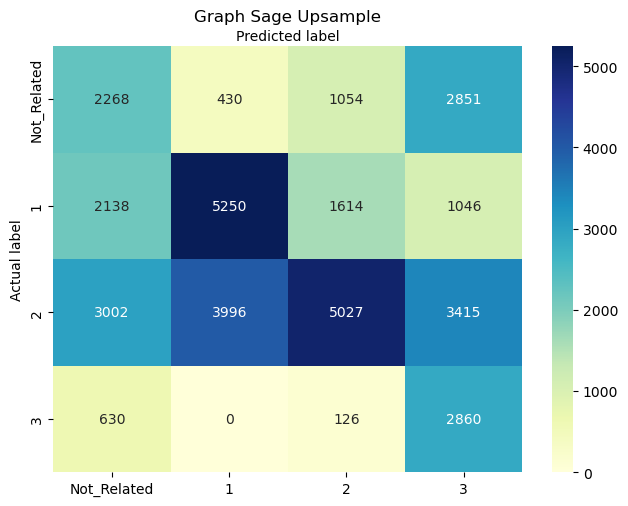

In [26]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n = metrics.confusion_matrix(clabels[cidx_test], cout[cidx_test])
#class_names=["Not_Related", "Related"]
class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [27]:
cnf_matrix_n[0][0]

2268

In [28]:
import sklearn

In [29]:
print(sklearn.metrics.classification_report(clabels[cidx_test], cout[cidx_test], target_names=class_names))

              precision    recall  f1-score   support

 Not_Related       0.28      0.34      0.31      6603
           1       0.54      0.52      0.53     10048
           2       0.64      0.33      0.43     15440
           3       0.28      0.79      0.41      3616

    accuracy                           0.43     35707
   macro avg       0.44      0.50      0.42     35707
weighted avg       0.51      0.43      0.44     35707



In [30]:
cnf_matrix_n

array([[2268,  430, 1054, 2851],
       [2138, 5250, 1614, 1046],
       [3002, 3996, 5027, 3415],
       [ 630,    0,  126, 2860]], dtype=int64)

In [31]:
#True Positive
True_Positive_0=cnf_matrix_n[0][0]
True_Positive_1=cnf_matrix_n[1][1]
True_Positive_2=cnf_matrix_n[2][2]
True_Positive_3=cnf_matrix_n[3][3]
#True Negative
True_Negatives_0=cnf_matrix_n[1][1]+cnf_matrix_n[1][2]+cnf_matrix_n[1][3]+cnf_matrix_n[2][1]+cnf_matrix_n[2][2]+cnf_matrix_n[2][3]+cnf_matrix_n[3][1]+cnf_matrix_n[3][2]+cnf_matrix_n[3][3]
True_Negatives_1=cnf_matrix_n[0][0]+cnf_matrix_n[0][2]+cnf_matrix_n[0][3]+cnf_matrix_n[2][0]+cnf_matrix_n[2][2]+cnf_matrix_n[2][3]+cnf_matrix_n[3][0]+cnf_matrix_n[3][2]+cnf_matrix_n[3][3]
True_Negatives_2=cnf_matrix_n[0][0]+cnf_matrix_n[0][1]+cnf_matrix_n[0][3]+cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][3]+cnf_matrix_n[3][0]+cnf_matrix_n[3][1]+cnf_matrix_n[3][3]
True_Negatives_3=cnf_matrix_n[0][0]+cnf_matrix_n[0][1]+cnf_matrix_n[0][2]+cnf_matrix_n[1][0]+cnf_matrix_n[1][1]+cnf_matrix_n[1][2]+cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][2]
#False Positive
False_Positive_0=cnf_matrix_n[1][0]+cnf_matrix_n[2][0]+cnf_matrix_n[3][0]
False_Positive_1=cnf_matrix_n[0][1]+cnf_matrix_n[2][1]+cnf_matrix_n[3][1]
False_Positive_2=cnf_matrix_n[0][2]+cnf_matrix_n[1][2]+cnf_matrix_n[3][2]
False_Positive_3=cnf_matrix_n[0][3]+cnf_matrix_n[1][3]+cnf_matrix_n[2][3]
#False Negative
False_Negative_0=cnf_matrix_n[0][1]+cnf_matrix_n[0][2]+cnf_matrix_n[0][3]
False_Negative_1=cnf_matrix_n[1][0]+cnf_matrix_n[1][2]+cnf_matrix_n[1][3]
False_Negative_2=cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][3]
False_Negative_3=cnf_matrix_n[3][0]+cnf_matrix_n[3][1]+cnf_matrix_n[3][2]

In [32]:
print("test_specificity_0/test_sensitivity_0: " + specificity(True_Negatives_0,False_Positive_0) +"/" +sensitivity(True_Positive_0,False_Negative_0)+
     "   test_specificity_1/test_sensitivity_1: " + specificity(True_Negatives_1,False_Positive_1) +"/" +sensitivity(True_Positive_1,False_Negative_1)+
    "   test_specificity_2/test_sensitivity_2: " + specificity(True_Negatives_2,False_Positive_2) +"/" +sensitivity(True_Positive_2,False_Negative_2)+
     "   test_specificity_3/test_sensitivity_3: " + specificity(True_Negatives_3,False_Positive_3) +"/" +sensitivity(True_Positive_1,False_Negative_3))

test_specificity_0/test_sensitivity_0: 0.8/0.34   test_specificity_1/test_sensitivity_1: 0.83/0.52   test_specificity_2/test_sensitivity_2: 0.87/0.33   test_specificity_3/test_sensitivity_3: 0.77/0.87


In [33]:
print(class_names[0])
print("Specificity: "+ specificity(True_Negatives_0,False_Positive_0))
print("Sensitivity: "+sensitivity(True_Positive_0,False_Negative_0))

print(class_names[1])
print("Specificity: "+specificity(True_Negatives_1,False_Positive_1))
print("Sensitivity: "+sensitivity(True_Positive_1,False_Negative_1))

print(class_names[2])
print("Specificity: "+specificity(True_Negatives_2,False_Positive_2))
print("Sensitivity: "+sensitivity(True_Positive_2,False_Negative_2))

print(class_names[3])
print("Specificity: "+specificity(True_Negatives_3,False_Positive_3))
print("Sensitivity: "+sensitivity(True_Positive_3,False_Negative_3))

Not_Related
Specificity: 0.8
Sensitivity: 0.34
1
Specificity: 0.83
Sensitivity: 0.52
2
Specificity: 0.87
Sensitivity: 0.33
3
Specificity: 0.77
Sensitivity: 0.79


Text(0.5, 427.9555555555555, 'Predicted label')

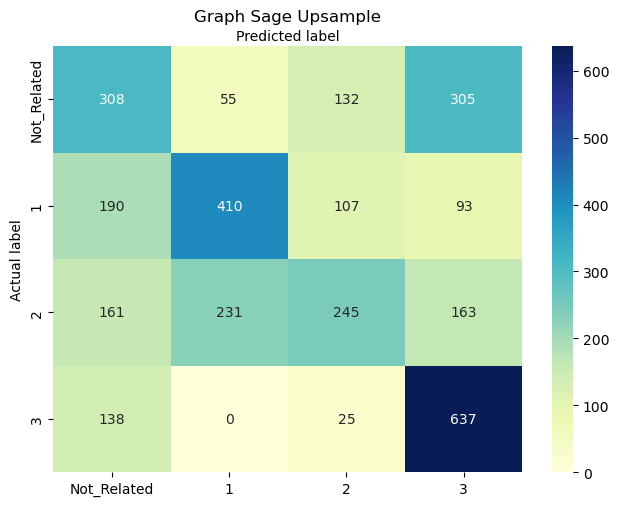

In [34]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n = metrics.confusion_matrix(clabels[cidx_valid], cout[cidx_valid])
#class_names=["Not_Related", "Related"]
class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [35]:
#True Positive
True_Positive_0=cnf_matrix_n[0][0]
True_Positive_1=cnf_matrix_n[1][1]
True_Positive_2=cnf_matrix_n[2][2]
True_Positive_3=cnf_matrix_n[3][3]
#True Negative
True_Negatives_0=cnf_matrix_n[1][1]+cnf_matrix_n[1][2]+cnf_matrix_n[1][3]+cnf_matrix_n[2][1]+cnf_matrix_n[2][2]+cnf_matrix_n[2][3]+cnf_matrix_n[3][1]+cnf_matrix_n[3][2]+cnf_matrix_n[3][3]
True_Negatives_1=cnf_matrix_n[0][0]+cnf_matrix_n[0][2]+cnf_matrix_n[0][3]+cnf_matrix_n[2][0]+cnf_matrix_n[2][2]+cnf_matrix_n[2][3]+cnf_matrix_n[3][0]+cnf_matrix_n[3][2]+cnf_matrix_n[3][3]
True_Negatives_2=cnf_matrix_n[0][0]+cnf_matrix_n[0][1]+cnf_matrix_n[0][3]+cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][3]+cnf_matrix_n[3][0]+cnf_matrix_n[3][1]+cnf_matrix_n[3][3]
True_Negatives_3=cnf_matrix_n[0][0]+cnf_matrix_n[0][1]+cnf_matrix_n[0][2]+cnf_matrix_n[1][0]+cnf_matrix_n[1][1]+cnf_matrix_n[1][2]+cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][2]
#False Positive
False_Positive_0=cnf_matrix_n[1][0]+cnf_matrix_n[2][0]+cnf_matrix_n[3][0]
False_Positive_1=cnf_matrix_n[0][1]+cnf_matrix_n[2][1]+cnf_matrix_n[3][1]
False_Positive_2=cnf_matrix_n[0][2]+cnf_matrix_n[1][2]+cnf_matrix_n[3][2]
False_Positive_3=cnf_matrix_n[0][3]+cnf_matrix_n[1][3]+cnf_matrix_n[2][3]
#False Negative
False_Negative_0=cnf_matrix_n[0][1]+cnf_matrix_n[0][2]+cnf_matrix_n[0][3]
False_Negative_1=cnf_matrix_n[1][0]+cnf_matrix_n[1][2]+cnf_matrix_n[1][3]
False_Negative_2=cnf_matrix_n[2][0]+cnf_matrix_n[2][1]+cnf_matrix_n[2][3]
False_Negative_3=cnf_matrix_n[3][0]+cnf_matrix_n[3][1]+cnf_matrix_n[3][2]

In [36]:
print(class_names[0])
print("Specificity: "+ specificity(True_Negatives_0,False_Positive_0))
print("Sensitivity: "+sensitivity(True_Positive_0,False_Negative_0))

print(class_names[1])
print("Specificity: "+specificity(True_Negatives_1,False_Positive_1))
print("Sensitivity: "+sensitivity(True_Positive_1,False_Negative_1))

print(class_names[2])
print("Specificity: "+specificity(True_Negatives_2,False_Positive_2))
print("Sensitivity: "+sensitivity(True_Positive_2,False_Negative_2))

print(class_names[3])
print("Specificity: "+specificity(True_Negatives_3,False_Positive_3))
print("Sensitivity: "+sensitivity(True_Positive_3,False_Negative_3))

Not_Related
Specificity: 0.8
Sensitivity: 0.38
1
Specificity: 0.88
Sensitivity: 0.51
2
Specificity: 0.88
Sensitivity: 0.31
3
Specificity: 0.77
Sensitivity: 0.8


In [37]:
print("valid_specificity_0/valid_sensitivity_0: " + specificity(True_Negatives_0,False_Positive_0) +"/" +sensitivity(True_Positive_0,False_Negative_0)+
     "   valid_specificity_1/valid_sensitivity_1: " + specificity(True_Negatives_1,False_Positive_1) +"/" +sensitivity(True_Positive_1,False_Negative_1)+
    "   valid_specificity_2/valid_sensitivity_2: " + specificity(True_Negatives_2,False_Positive_2) +"/" +sensitivity(True_Positive_2,False_Negative_2)+
     "   valid_specificity_3/valid_sensitivity_3: " + specificity(True_Negatives_3,False_Positive_3) +"/" +sensitivity(True_Positive_1,False_Negative_3))

valid_specificity_0/valid_sensitivity_0: 0.8/0.38   valid_specificity_1/valid_sensitivity_1: 0.88/0.51   valid_specificity_2/valid_sensitivity_2: 0.88/0.31   valid_specificity_3/valid_sensitivity_3: 0.77/0.72


In [38]:
test_labels=clabels[cidx_test]
test_output=cout[cidx_test]
valid_labels=clabels[cidx_valid]
valid_output=cout[cidx_valid]

In [39]:
test_labels_enc=np.eye(4)[test_labels]
test_output_enc=np.eye(4)[test_output]
valid_labels_enc=np.eye(4)[valid_labels]
valid_output_enc=np.eye(4)[valid_output]

In [40]:
roc_auc_score(test_labels_enc, test_output_enc,multi_class='ovr')

0.6557531426669697

In [41]:
roc_auc_score(valid_labels_enc, valid_output_enc,multi_class='ovr')

0.6666666666666666